# **Human Activity Recognition in Videos using CNN**

**Installing the require libraries**

In [ ]:
# Donot displays the output of this cell.
%%capture

# Install the required libraries.
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy
!pip install -q moviepy
!apt install imagemagick
!pip install imageio==2.4.1

**Importing the required libraries**

In [ ]:
# Import the required libraries.
#Libraries to perform basic functions
import os
import cv2
import pafy
import math
import random

#Libraries to perform basic operations on dataset
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

#Library to perform operations on videoclips
from moviepy.editor import *

#Library to split the train and test dataset
from sklearn.model_selection import train_test_split

#Libraries to build,train and test the model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2539520/45929032 bytes (5.5%)4808704/45929032 bytes (10.5%)7626752/45929032 bytes (16.6%)10190848/45929032 bytes (22.2%)12574720/45929032 bytes (27.4%)14794752/45929032 bytes (32.2%)17113088/45929032 bytes (37.3%)19537920/45929032 bytes (42.5%)21217280/45929032 bytes (46.2%)22773760/45929032 bytes (49.6%)25534464/45929032 bytes (55.6%)28336128/45929032 bytes (61.7%)

In [ ]:
# Done to decrease the level of randomness in the data and to make the data more consistent across all runs
seedConstant = 23
np.random.seed(seedConstant)
random.seed(seedConstant)
tf.random.set_seed(seedConstant)

**Downloading and extracting the dataset**

In [ ]:
#Donot displays the output of this cell.
%%capture

#Downlaod the UCF101 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar

#Extract the Dataset
!unrar x UCF101.rar

**Visualization of the dataset with its class labels**

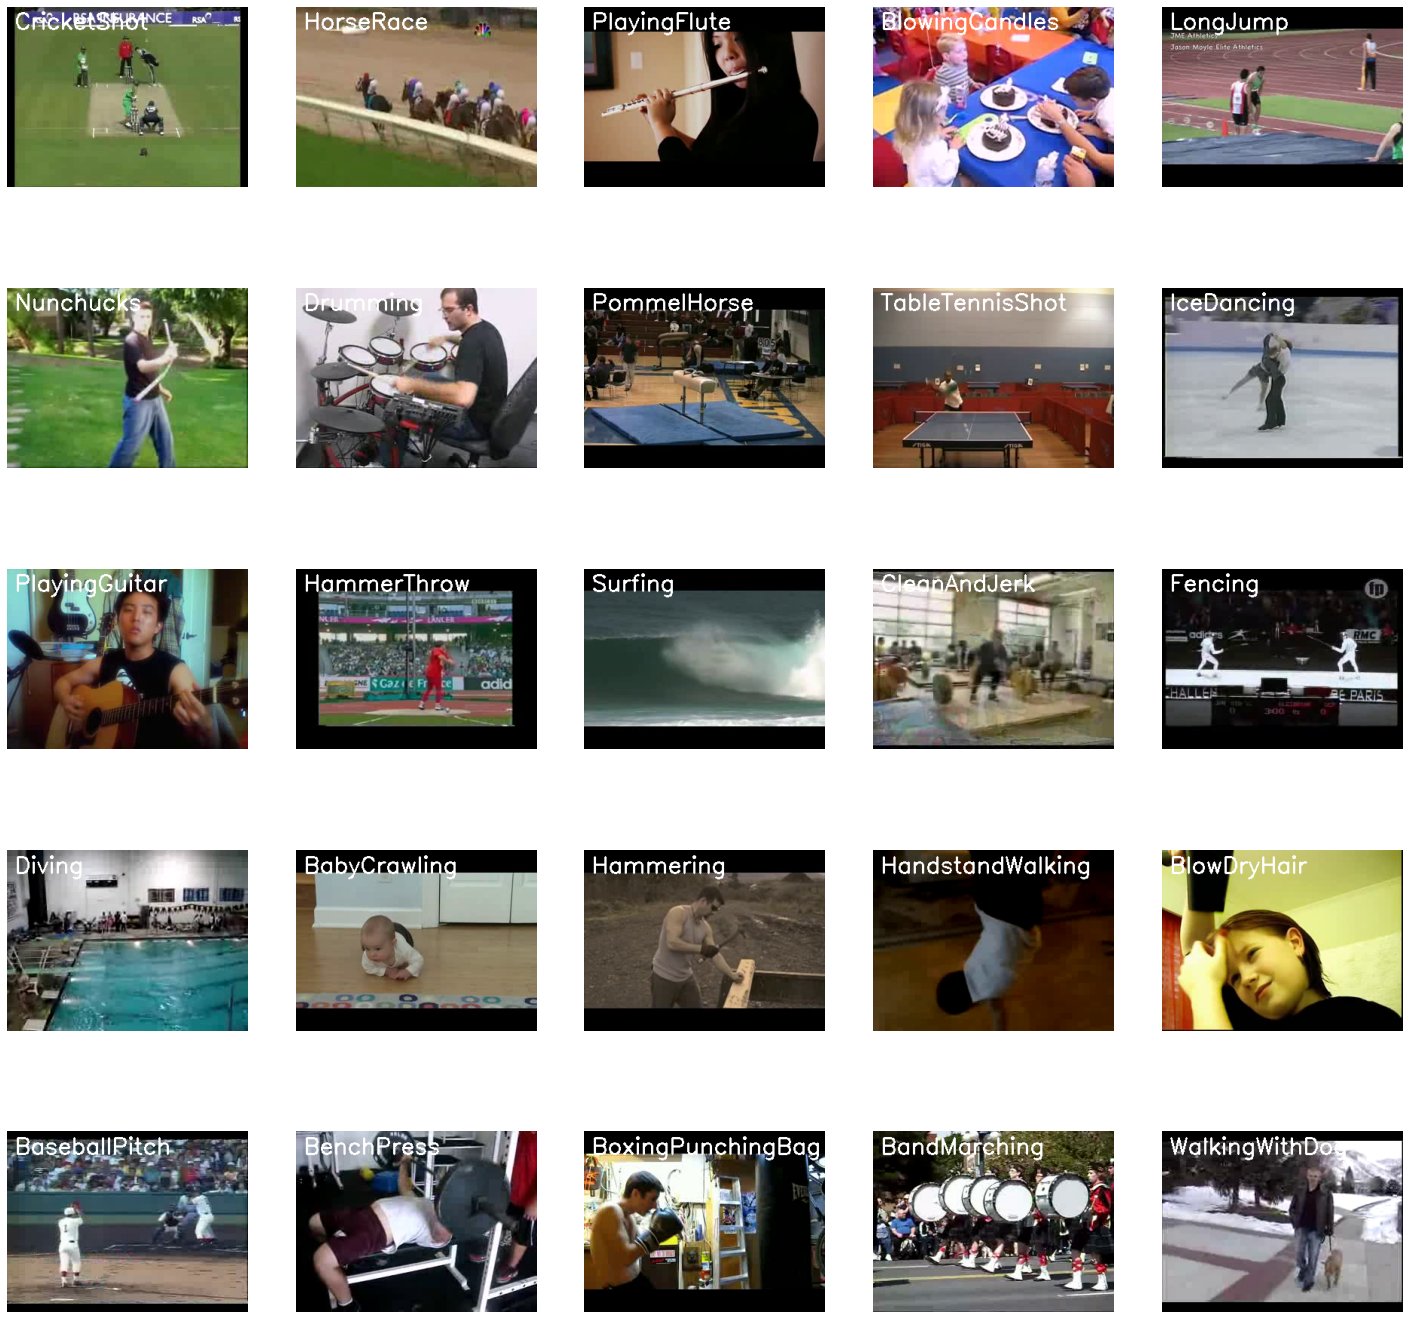

In [ ]:
# Create a Matplotlib figure and specify its dimensions
plt.figure(figsize = (25, 25))

# Get the names of all classes/categories in UCF101
allClassesNames = os.listdir('UCF-101')

# Generate a list of 25 random values.
randomRange = random.sample(range(len(allClassesNames)), 25)

# Iterating through all the generated random values.
for counter, randomIndex in enumerate(randomRange, 1):

    # Using the Random Index, retrieve a Class Name.
    selectedClassName = allClassesNames[randomIndex]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    videoFilesNamesList = os.listdir(f'UCF-101/{selectedClassName}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selectedVideoFileName = random.choice(videoFilesNamesList)

    # Initialize a VideoCapture object to read from the video File.
    videoReader = cv2.VideoCapture(f'UCF-101/{selectedClassName}/{selectedVideoFileName}')

    # Read the first frame of the video file.
    _, bgrFrame = videoReader.read()

    # Release the VideoCapture object.
    videoReader.release()

    # Convert the frame from BGR into RGB format. Open CV default color scheme: BGR
    rgbFrame = cv2.cvtColor(bgrFrame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgbFrame, selectedClassName, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 5, counter)
    plt.imshow(rgbFrame)
    plt.axis('off')

**Data Preprocessing**

**Initialization of some variables**

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
image_height , image_width = 64, 64

# Specify the directory containing the UCF101 dataset.
dataset_directory = "UCF-101"

# Specify the list containing the names of the classes used for training.
classes_list = ["ApplyLipstick","BabyCrawling","MilitaryParade","PlayingGuitar","CricketBowling"]

**Function to extract, resize and normalise frames**

In [ ]:
def framesExtraction(video_path):

    # Declare a list to store video frames.
    framesList = []

    # Read the Video File using the VideoCapture object.
    videoReader = cv2.VideoCapture(video_path)

    # Iterate through the Video Frames.
    while True:

        # Reading the frame from the video.
        success, frame = videoReader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resizedFrame = cv2.resize(frame, (image_height, image_width))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalizedFrame = resizedFrame / 255

        # Append the normalized frame into the frames list
        framesList.append(normalizedFrame)

    # Release the VideoCapture object.
    videoReader.release()

    # Return the frames list.
    return framesList

**Function to create dataset**

In [ ]:
def create_dataset():

    # Declared Empty Lists to store the features, labels and declaring the maximum number of images per class.
    features = []
    temp_features = []
    labels = []
    max_images_per_class = 7000

    # Iterating through all the classes mentioned in the classes list
    for classIndex, className in enumerate(classes_list):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {className}')

        # Get the list of video files present in the specific class name directory.
        filesList = os.listdir(os.path.join(dataset_directory, className))

        # Iterate through all the files present in the files list.
        for fileName in filesList:

            # Get the complete video path.
            videoFilePath = os.path.join(dataset_directory, className, fileName)

            # Extract the frames of the video file.
            frames = framesExtraction(videoFilePath)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)

        # Append the data to their repective lists.
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([classIndex] * max_images_per_class)

        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels

In [ ]:
# Create the dataset.
features, labels = create_dataset()

Extracting Data of Class: ApplyLipstick
Extracting Data of Class: BabyCrawling
Extracting Data of Class: MilitaryParade
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: CricketBowling


**One-hot encoding**

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
oneHotEncodedLabels = to_categorical(labels)

**Spliting the dataset into train and test data**

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
featuresTrain, featuresTest, labelsTrain, labelsTest = train_test_split(features, oneHotEncodedLabels, test_size = 0.25, shuffle = True,random_state = seedConstant)


**Constructing,Compiling and Training the model**

**Creating the function to construct the model**

In [ ]:
# Let's create a function that will construct our model
def createCNNModel():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(classes_list), activation = 'softmax'))

    # Printing the models summary
    model.summary()

    # Return the constructed LRCN model.
    return model


**Utilize the function** createCNNModel() **created above to construct the required `CNN` model.**

In [ ]:
# Calling the create_model method
CNNModel = createCNNModel()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

**Plotting the model structure**

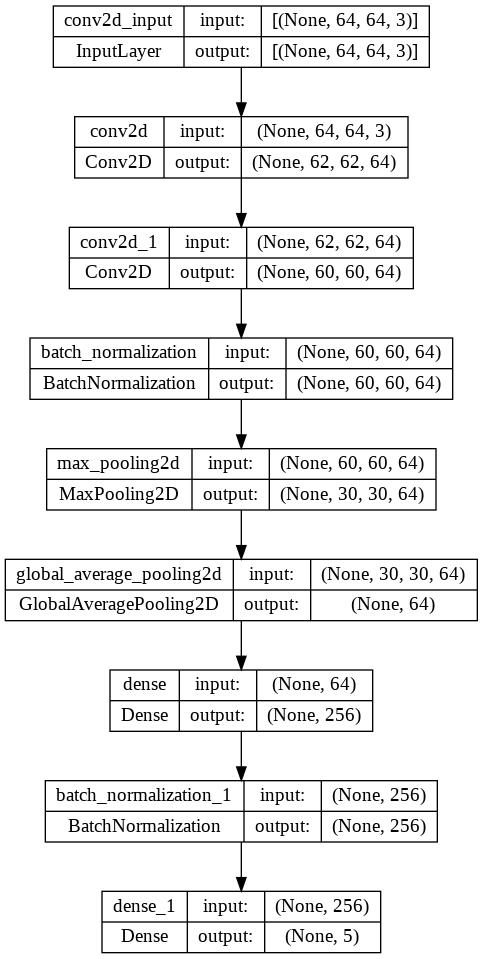

In [ ]:
plot_model(CNNModel, to_file = 'CNNModel_structure_plot.png', show_shapes = True, show_layer_names = True)

**Compiling & Training the model**

In [ ]:
# Create an Instance of Early Stopping Callback.
earlyStoppingCallback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
CNNModel.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
CNNmodelTrainingHistory = CNNModel.fit(x = featuresTrain, y = labelsTrain, epochs = 30, batch_size = 4 , shuffle = True, validation_split = 0.25, callbacks = [earlyStoppingCallback])

Epoch 1/30
4922/4922 [==============================] - 588s 119ms/step - loss: 0.7395 - accuracy: 0.7217 - val_loss: 1.0200 - val_accuracy: 0.6931
Epoch 2/30
4922/4922 [==============================] - 580s 118ms/step - loss: 0.3596 - accuracy: 0.8739 - val_loss: 0.1676 - val_accuracy: 0.9293
Epoch 3/30
4922/4922 [==============================] - 588s 119ms/step - loss: 0.2532 - accuracy: 0.9134 - val_loss: 0.0900 - val_accuracy: 0.9767
Epoch 4/30
4922/4922 [==============================] - 579s 118ms/step - loss: 0.2053 - accuracy: 0.9327 - val_loss: 0.0692 - val_accuracy: 0.9774
Epoch 5/30
4922/4922 [==============================] - 580s 118ms/step - loss: 0.1572 - accuracy: 0.9492 - val_loss: 0.1533 - val_accuracy: 0.9610
Epoch 6/30
4922/4922 [==============================] - 578s 117ms/step - loss: 0.1393 - accuracy: 0.9562 - val_loss: 0.1625 - val_accuracy: 0.9444
Epoch 7/30
4922/4922 [==============================] - 579s 118ms/step - loss: 0.1278 - accuracy: 0.9615 - val_

**Evaluating the trained Model**

In [ ]:
modelEvaluationHistory = CNNModel.evaluate(featuresTest, labelsTest)

274/274 [==============================] - 51s 184ms/step - loss: 0.0093 - accuracy: 0.9982


**Saving the model**

In [ ]:
modelEvaluationLoss, modelEvaluationAccuracy = modelEvaluationHistory
modelFileName = f'Model___Loss_{modelEvaluationLoss}___Accuracy_{modelEvaluationAccuracy}.h5'

# Saving the Model
CNNModel.save(modelFileName)

**Defining the function to plot the accuracy and loss graphs**

In [ ]:
def plotMetric(modelTrainingHistory, metricName_1, metricName_2, plotName):

    # Get metric values using metric names as identifiers.
    metricValue_1 = modelTrainingHistory.history[metricName_1]
    metricValue_2 = modelTrainingHistory.history[metricName_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metricValue_1))

    # Plot the Graph.
    plt.plot(epochs, metricValue_1, 'green', label = metricName_1)
    plt.plot(epochs, metricValue_2, 'red', label = metricName_2)

    # Add title to the plot.
    plt.title(str(plotName))

    # Add legend to the plot.
    plt.legend()

**Plotting the Accuracy and Loss Graphs**

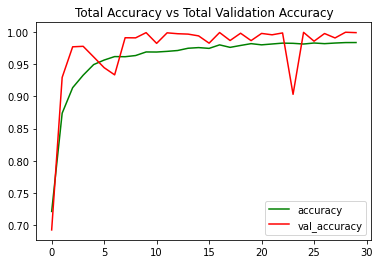

In [ ]:
# Visualize the training and validation accuracy metrices.
plotMetric(CNNmodelTrainingHistory, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

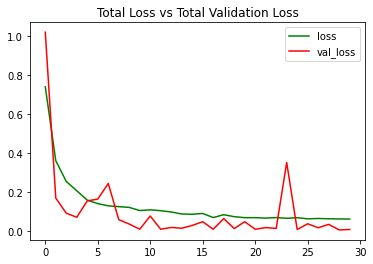

In [ ]:
# Visualize the training and validation loss metrices.
plotMetric(CNNmodelTrainingHistory, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

**Prediction of Model**

**Function to download youtube videos**

In [ ]:
def downloadYoutubeVideos(youtubeVideourl, outputDirectory):

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtubeVideourl)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     bestVideo = video.getbest()

     # Construct the output file path.
     outputFilePath = f'{outputDirectory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     bestVideo.download(filepath = outputFilePath, quiet = True)

     # Return the video title.
     return title

**Download the test Video**

In [ ]:
# Make the Output directory if it does not exist
testVideosDirectory = 'test_videos'
os.makedirs(testVideosDirectory, exist_ok = True)

# Download a YouTube Video.
videoTitle = downloadYoutubeVideos('https://www.youtube.com/watch?v=sSKM8XyZC14', testVideosDirectory)

# Get the YouTube Video's path we just downloaded.
inputVideoFilePath = f'{testVideosDirectory}/{videoTitle}.mp4'

**Function to recognise the activity on video**

In [ ]:
def predictOnVideo(videoFilePath, outputFilePath, windowSize):

    # Declare a queue to store video frames
    predictedLabelsProbabilitiesDeque = deque(maxlen = windowSize)

    originalVideoHeight = int(videoReader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    originalVideoWidth = int(videoReader.get(cv2.CAP_PROP_FRAME_WIDTH))


    # Initialize the VideoWriter Object to store the output video in the disk.
    videoWriter = cv2.VideoWriter(outputFilePath, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   videoReader.get(cv2.CAP_PROP_FPS), (originalVideoWidth, originalVideoHeight))

    # Initialize a variable to store the predicted action being performed in the video.
    predictedClassName = ''
    # Iterate until the video is accessed successfully.
    while True:

        # Read the frame.
        ok, frame = videoReader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resizedFrame = cv2.resize(frame, (image_height , image_width))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalizedFrame = resizedFrame / 255

        predictedLabelsProbabilities = CNNModel.predict(np.expand_dims(normalizedFrame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predictedLabelsProbabilitiesDeque.append(predictedLabelsProbabilities)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(predictedLabelsProbabilitiesDeque) == windowSize:

            predictedLabelsProbabilitiesNPArray = np.array(predictedLabelsProbabilitiesDeque)

            # Calculating Average of Predicted Labels Probabilities Column Wise
            predictedLabelsProbabilitiesAveraged = predictedLabelsProbabilitiesNPArray.mean(axis = 0)

            # Get the index of class with highest probability.
            predictedLabel = np.argmax(predictedLabelsProbabilities)

            # Get the class name using the retrieved index.
            predictedClassName = classes_list[predictedLabel]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predictedClassName, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        videoWriter.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    videoReader.release()
    videoWriter.release()

**Action recognition on test video**

In [ ]:
# Construct the output video path.
windowSize = 1
outputVideoFilePath = f'{testVideosDirectory}/{videoTitle}.mp4'

# Perform Action Recognition on the Test Video.
predictOnVideo(inputVideoFilePath, outputVideoFilePath, windowSize)

# Display the output video.
VideoFileClip(outputVideoFilePath, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 884/884 [00:06<00:00, 130.78it/s]
